# Import Statements

In [1]:
import numpy as np
import pandas as pd
import time
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

# Reading the Data

In [2]:
vmtable = pd.read_csv('D:/FYP/AzureDatasetPacking2019/VM Table/vmtable.csv.gz', compression='gzip', 
                      names=['vm id', 'subscription id', 'deployment id', 'timestamp vm created', 'timestamp vm deleted', 
                             'max cpu', 'avg cpu', 'p95 max cpu', 'vm category', 'vm virtual core count', 
                             'vm memory (gb)'], sep=',', quotechar='"')

# Pre-Process the Data
## Calculate the lifetime of each VM (in minutes)

In [3]:
vmtable['lifetime'] = (vmtable['timestamp vm deleted'] - vmtable['timestamp vm created'])/60

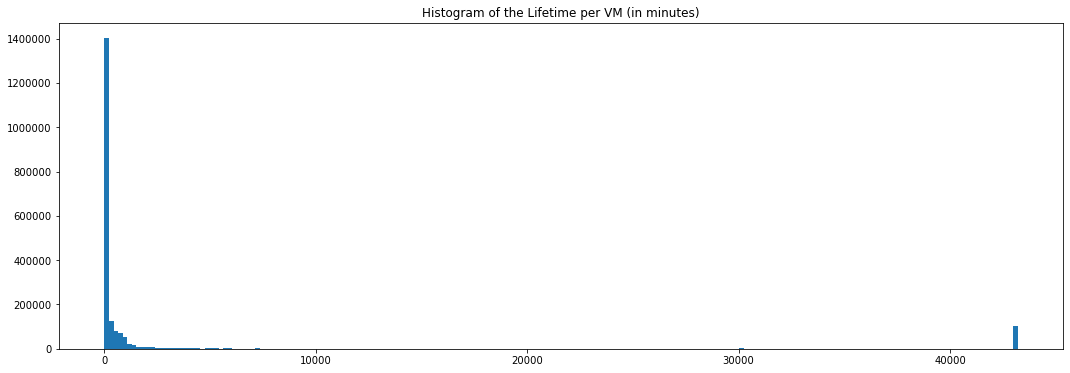

In [4]:
# spread of VM lifetimes
plt.figure(figsize=(18,6))
plt.hist(vmtable['lifetime'], bins=200)
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Histogram of the Lifetime per VM (in minutes)')
plt.show()

## Convert Timestamp into Date-Time formatt for the creation and deletion of each VM
Python assumes that timestamp 0 is the date 1970-01-01, but for this data set timestamp 0 is [insert correct date] and the final timestamp is equivalent to [insert correct date]

In [5]:
datetime_create = []
datetime_delete = []
# python assums timestamp 0 = 1970-01-01, for this data set 0 =July 15th 2019 and dataset ends July 28th 2019.
no_days_difference = datetime(2019, 7, 15, 0, 0) - datetime(1970, 1, 1, 0, 0) # = 18092
for ind, row in vmtable.iterrows():
    datetime_create.append(datetime.fromtimestamp(row['timestamp vm created']) + timedelta(days=18092))
    datetime_delete.append(datetime.fromtimestamp(row['timestamp vm deleted']) + timedelta(days=18092))
vmtable['datetime_creation'] = datetime_create
vmtable['datetime_deletion'] = datetime_delete
vmtable.head()

,vm id,subscription id,deployment id,timestamp vm created,timestamp vm deleted,max cpu,avg cpu,p95 max cpu,vm category,vm virtual core count,vm memory (gb),lifetime,datetime_creation,datetime_deletion
0,x/XsOfHO4ocsV99i4NluqKDuxctW2MMVmwqOPAlg4wp8mq...,VDU4C8cqdr+ORcqquwMRcsBA2l0SC6lCPys0wdghKROuxP...,Pc2VLB8aDxK2DCC96itq4vW/zVDp4wioAUiB3HoGSFYQ0o...,0,2591700,99.369869,3.424094,10.194309,Delay-insensitive,1,1.75,43195.0,2019-07-15 00:00:00,2019-08-13 23:55:00
1,H5CxmMoVcZSpjgGbohnVA3R+7uCTe/hM2ht2uIYi3t7KwX...,BSXOcywx8pUU0DueDo6UMol1YzR6tn47KLEKaoXp0a1bf2...,3J17LcV4gXjFat62qhVFRfoiWArHnY763HVqqI6orJCfV8...,0,1539300,100.000000,6.181784,33.981360,Interactive,1,0.75,25655.0,2019-07-15 00:00:00,2019-08-01 19:35:00
2,wR/G1YUjpMP4zUbxGM/XJNhYS8cAK3SGKM2tqhF7VdeTUY...,VDU4C8cqdr+ORcqquwMRcsBA2l0SC6lCPys0wdghKROuxP...,Pc2VLB8aDxK2DCC96itq4vW/zVDp4wioAUiB3HoGSFYQ0o...,2188800,2591700,99.569027,3.573635,7.924250,Delay-insensitive,1,1.75,6715.0,2019-08-09 08:00:00,2019-08-13 23:55:00
3,1XiU+KpvIa3T1XP8kk3ZY71Of03+ogFL5Pag9Mc2jBuh0Y...,8u+M3WcFp8pq183WoMB79PhK7xUzbaviOBv0qWN6Xn4mbu...,DHbeI+pYTYFjH8JAF8SewM0z/4SqQctvxcBRGIRglBmeLW...,0,2591700,99.405085,16.287611,95.697890,Delay-insensitive,8,56.00,43195.0,2019-07-15 00:00:00,2019-08-13 23:55:00
4,z5i2HiSaz6ZdLR6PXdnDjGva3jIlkMPXx23VtfXx9q3dXF...,VDU4C8cqdr+ORcqquwMRcsBA2l0SC6lCPys0wdghKROuxP...,Pc2VLB8aDxK2DCC96itq4vW/zVDp4wioAUiB3HoGSFYQ0o...,0,2188500,98.967961,3.036038,9.445484,Delay-insensitive,1,1.75,36475.0,2019-07-15 00:00:00,2019-08-09 07:55:00


The above code originally formatted the timestamp 0 as equivalent to 2019-07-15. This will be rectified below (after the aggregation).
## Create a list of each five-minute interval from the time the first VM is created until the final VM is deleted

In [6]:
lifetime_range = pd.period_range(min(vmtable["datetime_creation"]), max(vmtable["datetime_deletion"]), freq="5min")
lifetime_range = list(lifetime_range.to_timestamp().to_pydatetime())

Use each five-minute interval as a key in a dictionary (to be populated with the aggregated average, maximum, 95^th percentile maximum, core count and memory used within that time)

In [7]:
new_agg_vmtable = {}
for i in lifetime_range:
    # unique time interval = {avg cpu: 0, max cpu: 0, p95 max cpu: 0, core count: 0, memory: 0}
    new_agg_vmtable[i] = [0, 0, 0, 0, 0]

## Aggregate the CPU and Memory Usage from the data set into five-minute intervals
(Due to the size of the data set this takes several days)
#### The Process
1. Get the creation and deletion datetime for each VM. If the datetime is not a multiple of five minutes, round it to the time interval that the VM is started within and apply a fractional weight which is equivalent to the percentage of the five minute interval that the VM is active for. For datetimes that are a multiple of five, a weight of one is applied.
2. For each five minute interval between the creation and deletion of each VM, the average, maximum, 95th percentile maximum, core count and memory usage are added to the dictionary new_agg_vmtable.

In [ ]:
"""
start = time.time()
lt_rng = None
# s_weights = []
# e_weights = []
p = [1, 2, 4, 5, 12, 10, 15, 20, 25, 30, 45,50]
n = len(vmtable["datetime_creation"])
for i in range(n):
    st = vmtable.iloc[i, :]["datetime_creation"]
    et = vmtable.iloc[i, :]["datetime_deletion"]
    if st.minute % 5 != 0:
        # start_time = st.dt.floor("5min")
        start_time = st.floor("5min")
        # start_weight = ((st.dt.second - start_time.dt.second) + (60 * (st.dt.minute - start_time.dt.minute))) / (60 * 5)
        start_weight = ((st.second - start_time.second) + (60 * (st.minute - start_time.minute))) / (60 * 5)
    else:
        start_time = st
        start_weight = 1
    if et.minute % 5 != 0:
        # end_time = et.dt.floor("5min")
        end_time = et.floor("5min")
        # end_weight = ((et.dt.second - end_time.dt.second) + (60 * (et.dt.minute - end_time.dt.minute))) / (60 * 5)
        end_weight = ((et.second - end_time.second) + (60 * (et.minute - end_time.minute))) / (60 * 5)
    else:
        end_time = et
        end_weight = 1
    lt_rnge = lifetime_range[lifetime_range.index(start_time):lifetime_range.index(end_time)] 
    # list(pd.period_range(start_time, end_time, freq="5min"))
    # print(len(lt_rnge))
    if len(lt_rnge) < 1000: # removing highly computationally complex rows, to test speed
        for j in lt_rnge:
            current_usage = new_agg_vmtable[j]
            if lt_rnge.index(j) == 0:
                new_agg_vmtable[j] = [((vmtable.iloc[i, :]["avg cpu"] * start_weight) + current_usage[0]), 
                                  ((vmtable.iloc[i, :]["max cpu"]) + current_usage[1]),
                                  ((vmtable.iloc[i, :]["p95 max cpu"]) + current_usage[2]), 
                                  (vmtable.iloc[i, :]["vm virtual core count"] + current_usage[3]),
                                  (vmtable.iloc[i, :]["vm memory (gb)"] + current_usage[4])]
            elif lt_rnge.index(j) == n:
                new_agg_vmtable[j] = [((vmtable.iloc[i, :]["avg cpu"] * end_weight) + current_usage[0]), 
                                  ((vmtable.iloc[i, :]["max cpu"]) + current_usage[1]),
                                  ((vmtable.iloc[i, :]["p95 max cpu"]) + current_usage[2]), 
                                  (vmtable.iloc[i, :]["vm virtual core count"] + current_usage[3]),
                                  (vmtable.iloc[i, :]["vm memory (gb)"] + current_usage[4])]
            else:
                new_agg_vmtable[j] = [(vmtable.iloc[i, :]["avg cpu"] + current_usage[0]), 
                                  (vmtable.iloc[i, :]["max cpu"] + current_usage[1]),
                                  (vmtable.iloc[i, :]["p95 max cpu"] + current_usage[2]), 
                                  (vmtable.iloc[i, :]["vm virtual core count"] + current_usage[3]),
                                  (vmtable.iloc[i, :]["vm memory (gb)"] + current_usage[4])]
    lt_rng = []
    if round((time.time() - start)/60) in p:
        print("%: ",(i/n) * 100,"\n time taken: ", (time.time() - start) / 60, "\n")
        p.remove(round((time.time() - start)/60))
end = time.time()
print((end-start)/60)
# new_agg_vmtable
"""

## The Aggregated VM Table
Load this instead of running the above code

In [26]:
aggregation_vmtable = pd.read_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/agg_vmtable_copy.csv", header=0, 
                                  names= ["index", "avg_cpu", "max_cpu", "p95_max_cpu", "vm_virtual_core_count",
                                          "vm_memory_gb"])
aggregation_vmtable.head()

,index,avg_cpu,max_cpu,p95_max_cpu,vm_virtual_core_count,vm_memory_gb
0,2019-07-15 00:00:00,600026.793129,4.041458e+06,2.139499e+06,126757,335558.00
1,2019-07-15 00:05:00,600971.042478,4.044738e+06,2.141563e+06,126712,335395.25
2,2019-07-15 00:10:00,600301.813291,4.042657e+06,2.139025e+06,126516,334882.25
3,2019-07-15 00:15:00,599839.457380,4.042293e+06,2.138133e+06,126402,334636.75
4,2019-07-15 00:20:00,598782.239829,4.041869e+06,2.136908e+06,126265,334311.00


#### Fixing the datetime columns to show the correct dates
The VM's in this dataset run from 2016-11-16 until 2017-02-16.
The dataset was previously calculated for the dates 2019-07-15 until 2019-07-28.

We assumed the data collection began at 00:00 on these dates. No other data was found to contradict this.

The Resolution:
1. Calculate the number of days between the two start dates (971 days)
2. Reduce the datetimes in the aggregated VM table by the difference.

In [27]:
days_difference = datetime(2019, 7, 15, 0, 0) - datetime(2016, 11, 16, 0, 0) # 971 days
aggregation_vmtable = aggregation_vmtable.reset_index()
aggregation_vmtable["index"] = pd.to_datetime(aggregation_vmtable["index"]) - timedelta(days=971)
aggregation_vmtable = aggregation_vmtable.set_index("index")
aggregation_vmtable = aggregation_vmtable[["avg_cpu", "max_cpu", "p95_max_cpu", "vm_virtual_core_count", "vm_memory_gb"]]
aggregation_vmtable.tail()

,avg_cpu,max_cpu,p95_max_cpu,vm_virtual_core_count,vm_memory_gb
index,,,,,
2016-12-15 23:35:00,625220.260839,4.478651e+06,2.229860e+06,129979,337958.75
2016-12-15 23:40:00,622813.265551,4.468815e+06,2.223262e+06,129731,337061.75
2016-12-15 23:45:00,619207.294106,4.450889e+06,2.209649e+06,129230,336097.00
2016-12-15 23:50:00,615505.559907,4.433751e+06,2.196580e+06,128805,334848.25
2016-12-15 23:55:00,0.000000,0.000000e+00,0.000000e+00,0,0.00
